In [2]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt

In [3]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [283]:
bucket = "demo-copy1"  # replace with an existing bucket if needed
prefix = 'deepar-erp-notebook'    # prefix used for all data stored within the bucket


sagemaker_session = sagemaker.Session()
role = get_execution_role()


s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [284]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

In [419]:
freq = '1D'
prediction_length = 10
context_length = 60


In [420]:
data = pd.read_csv("testing.csv", index_col=0, parse_dates=True, decimal=',')

In [421]:
len(data)

16938

In [422]:
a = data.loc["2004-01-02":"2019-04-01"]["ASPFWR5"]
a = a.asfreq('1D')
train_data = a.fillna(method='ffill').fillna(method='bfill')
train_data = [float(i) for i in train_data]
index = pd.to_datetime(a.index)
# pd.DatetimeIndex(start=t0, freq=freq, periods=data_length)
time_series = pd.Series(data=train_data, index=a.index)

In [423]:
time_series[0]

0.0102034784219897

In [424]:
t0 = '2004-01-02 00:00:00'
data_length = len(a)
num_ts = 1

In [425]:
a.index

DatetimeIndex(['2004-01-02', '2004-01-03', '2004-01-04', '2004-01-05',
               '2004-01-06', '2004-01-07', '2004-01-08', '2004-01-09',
               '2004-01-10', '2004-01-11',
               ...
               '2019-03-23', '2019-03-24', '2019-03-25', '2019-03-26',
               '2019-03-27', '2019-03-28', '2019-03-29', '2019-03-30',
               '2019-03-31', '2019-04-01'],
              dtype='datetime64[ns]', name='DATE', length=5569, freq='D')

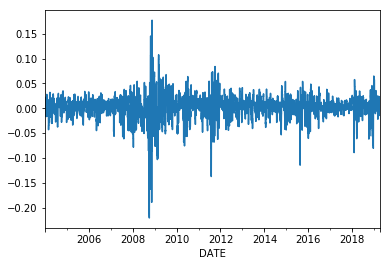

In [426]:
time_series.plot()
plt.show()

In [427]:
time_series_training = time_series

In [428]:
prediction_length

10

In [429]:
time_series_training

DATE
2004-01-02    0.010203
2004-01-03    0.010203
2004-01-04    0.010203
2004-01-05    0.006742
2004-01-06   -0.000082
2004-01-07    0.004862
2004-01-08    0.003348
2004-01-09    0.016064
2004-01-10    0.016064
2004-01-11    0.016064
2004-01-12    0.008441
2004-01-13    0.022136
2004-01-14    0.011211
2004-01-15    0.005521
2004-01-16    0.014082
2004-01-17    0.014082
2004-01-18    0.014082
2004-01-19    0.014082
2004-01-20    0.004024
2004-01-21   -0.015314
2004-01-22   -0.011733
2004-01-23   -0.008505
2004-01-24   -0.008505
2004-01-25   -0.008505
2004-01-26   -0.016703
2004-01-27   -0.008048
2004-01-28   -0.004767
2004-01-29   -0.002817
2004-01-30    0.008341
2004-01-31    0.008341
                ...   
2019-03-03   -0.021950
2019-03-04   -0.003910
2019-03-05    0.001214
2019-03-06    0.013886
2019-03-07    0.021647
2019-03-08    0.024183
2019-03-09    0.024183
2019-03-10    0.024183
2019-03-11    0.013406
2019-03-12    0.009890
2019-03-13    0.000278
2019-03-14    0.012149
2019-0

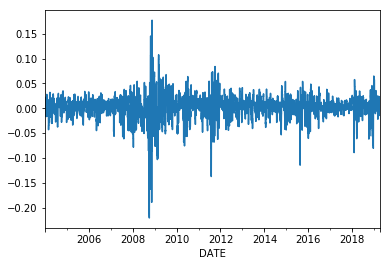

In [430]:
time_series_training.plot()

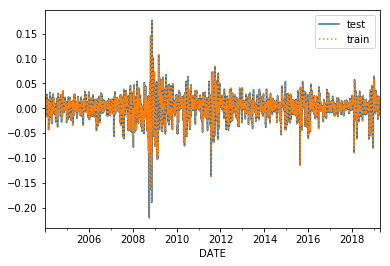

In [431]:
time_series.plot(label='test')
time_series_training.plot(label='train', ls=':')
plt.legend()
plt.show()

In [432]:
time_series_training[0]

0.0102034784219897

In [433]:
e = data.loc["2019-04-01":"2019-04-18"]["ASPFWR5"]
e = e.asfreq('1D')
eval_data = e.fillna(method='ffill').fillna(method='bfill')
eval_data = [float(i) for i in eval_data]
eval_index = pd.to_datetime(e.index)
# pd.DatetimeIndex(start=t0, freq=freq, periods=data_length)
eval_time_series = pd.Series(data=eval_data, index=e.index)

In [434]:
eval_time_series

DATE
2019-04-01    0.009832
2019-04-02    0.004204
2019-04-03    0.006038
2019-04-04    0.003112
2019-04-05    0.005029
2019-04-06    0.005029
2019-04-07    0.005029
2019-04-08    0.003615
2019-04-09    0.009409
2019-04-10    0.003554
2019-04-11    0.003554
2019-04-12    0.003554
2019-04-13    0.003554
2019-04-14    0.003554
2019-04-15    0.003554
2019-04-16    0.003554
2019-04-17    0.003554
2019-04-18    0.003554
Freq: D, dtype: float64

In [435]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": ts.tolist()}
    print(obj)
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [436]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    fp.write(series_to_jsonline(time_series).encode(encoding))
    fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    fp.write(series_to_jsonline(eval_time_series).encode(encoding))
    fp.write('\n'.encode(encoding))

{'start': '2004-01-02 00:00:00', 'target': [0.0102034784219897, 0.0102034784219897, 0.0102034784219897, 0.00674238151785269, -8.18517220091041e-05, 0.00486202040745925, 0.00334812605055816, 0.0160642073199737, 0.0160642073199737, 0.0160642073199737, 0.0084414478363435, 0.0221361868209451, 0.0112109791568255, 0.00552119810945332, 0.0140819395748605, 0.0140819395748605, 0.0140819395748605, 0.0140819395748605, 0.00402356036532123, -0.0153137414617467, -0.011733047736492, -0.0085050167896209, -0.0085050167896209, -0.0085050167896209, -0.016702792041212, -0.00804844173761431, -0.0047670949188084, -0.00281667655403501, 0.00834128175221087, 0.00834128175221087, 0.00834128175221087, 0.00429400796475714, 0.00918769883848036, 0.0279595429055538, 0.0214119485718347, 0.00574571268902696, 0.00574571268902696, 0.00574571268902696, 0.0144755044687807, 0.00684843330386513, -0.00744264599431408, -0.00685943652112484, -0.00488089611062902, -0.00488089611062902, -0.00488089611062902, -0.00488089611062902

In [437]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='deepar-erp-notebook',
    output_path="s3://" + s3_output_path
)

In [438]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "64",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [439]:
estimator.set_hyperparameters(**hyperparameters)


In [440]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

2020-06-16 18:02:11 Starting - Starting the training job...
2020-06-16 18:02:13 Starting - Launching requested ML instances......
2020-06-16 18:03:20 Starting - Preparing the instances for training...
2020-06-16 18:04:01 Downloading - Downloading input data...
2020-06-16 18:04:13 Training - Downloading the training image...
2020-06-16 18:04:55 Training - Training image download completed. Training in progress.Arguments: train
[06/16/2020 18:04:57 INFO 140302452488000] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'au

[06/16/2020 18:05:06 INFO 140302452488000] Epoch[3] Batch[0] avg_epoch_loss=-2.702792
[06/16/2020 18:05:06 INFO 140302452488000] #quality_metric: host=algo-1, epoch=3, batch=0 train loss <loss>=-2.70279192924
[06/16/2020 18:05:07 INFO 140302452488000] Epoch[3] Batch[5] avg_epoch_loss=-2.712325
[06/16/2020 18:05:07 INFO 140302452488000] #quality_metric: host=algo-1, epoch=3, batch=5 train loss <loss>=-2.71232533455
[06/16/2020 18:05:07 INFO 140302452488000] Epoch[3] Batch [5]#011Speed: 460.13 samples/sec#011loss=-2.712325
[06/16/2020 18:05:07 INFO 140302452488000] Epoch[3] Batch[10] avg_epoch_loss=-2.725356
[06/16/2020 18:05:07 INFO 140302452488000] #quality_metric: host=algo-1, epoch=3, batch=10 train loss <loss>=-2.74099378586
[06/16/2020 18:05:07 INFO 140302452488000] Epoch[3] Batch [10]#011Speed: 438.22 samples/sec#011loss=-2.740994
[06/16/2020 18:05:07 INFO 140302452488000] processed a total of 665 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2186.924934387207,

[06/16/2020 18:05:21 INFO 140302452488000] Epoch[10] Batch[0] avg_epoch_loss=-3.011906
[06/16/2020 18:05:21 INFO 140302452488000] #quality_metric: host=algo-1, epoch=10, batch=0 train loss <loss>=-3.01190590858
[06/16/2020 18:05:22 INFO 140302452488000] Epoch[10] Batch[5] avg_epoch_loss=-3.068126
[06/16/2020 18:05:22 INFO 140302452488000] #quality_metric: host=algo-1, epoch=10, batch=5 train loss <loss>=-3.068125844
[06/16/2020 18:05:22 INFO 140302452488000] Epoch[10] Batch [5]#011Speed: 457.86 samples/sec#011loss=-3.068126
[06/16/2020 18:05:22 INFO 140302452488000] processed a total of 629 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2043.8458919525146, "sum": 2043.8458919525146, "min": 2043.8458919525146}}, "EndTime": 1592330722.910775, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1592330720.866754}

[06/16/2020 18:05:22 INFO 140302452488000] #throughput_metric: host=algo-1, train throughput=307.733257126 reco

[06/16/2020 18:05:35 INFO 140302452488000] Epoch[16] Batch[10] avg_epoch_loss=-3.299244
[06/16/2020 18:05:35 INFO 140302452488000] #quality_metric: host=algo-1, epoch=16, batch=10 train loss <loss>=-3.30422515869
[06/16/2020 18:05:35 INFO 140302452488000] Epoch[16] Batch [10]#011Speed: 459.48 samples/sec#011loss=-3.304225
[06/16/2020 18:05:35 INFO 140302452488000] processed a total of 697 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2213.7718200683594, "sum": 2213.7718200683594, "min": 2213.7718200683594}}, "EndTime": 1592330735.994065, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1592330733.780211}

[06/16/2020 18:05:35 INFO 140302452488000] #throughput_metric: host=algo-1, train throughput=314.827055595 records/second
[06/16/2020 18:05:35 INFO 140302452488000] #progress_metric: host=algo-1, completed 85 % of epochs
[06/16/2020 18:05:35 INFO 140302452488000] #quality_metric: host=algo-1, epoch=16, train loss <l


2020-06-16 18:05:53 Uploading - Uploading generated training model
2020-06-16 18:05:53 Completed - Training job completed
Training seconds: 112
Billable seconds: 112


In [445]:
estimator.latest_training_job.name

'deepar-erp-notebook-2020-06-16-18-02-11-023'

In [444]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.c4.xlarge',
    deployment_image=image_name,
    role=role
)

ValueError: Endpoint with name "deepar-erp-notebook-2020-06-16-18-02-11-023" already exists; please pick a different name.

In [ ]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=800, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = ts.index[-1]+1
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts, cat if cat else None)]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        prediction_index = pd.DatetimeIndex(start=prediction_times, freq=self.freq, periods=self.prediction_length)
        list_of_df.append(pd.DataFrame(data=response_data['predictions'][0]['quantiles'], index=prediction_index))
        return list_of_df

In [ ]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)


In [ ]:
list_of_df = predictor.predict(time_series_training)
actual_data = time_series


In [ ]:
list_of_df

In [ ]:
len(list_of_df[0])

In [ ]:
# No feature vector only time series. Prediction length = 48. Context length = 72
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    eval_time_series.plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

In [ ]:
# No feature vector only time series. Prediction length = 326. Context length = 72
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    eval_time_series.plot(label='target')
    p10 = list_of_df[0]['0.1']
    p90 = list_of_df[0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[0]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

In [ ]:
print("asd")